## Portfolio Replication and Hedging: From a Deep Reinforcement Learning's Perspective

                                                 Candidate Number: 39290, 25882

                                                             Abstract

Transaction cost makes financial market incomplete, and Delta hedging may not be the optimal solution for dynamic h. The authors propose to use solve the fundamental problem of option hedging subject to discrete trading, using state-of-the-art Reinforcement Learning (RL) techniques, including deep
Q-Network(DQN), Deep Deterministic Policy Gradient(DDPG) and Proximal Policy Optimization(PPO). Each algorithm is trained under two scenarios: zero transaction cost and non-zero transaction cost, where for each scenario we have different parameters such as trading frequency, risk-aversion and transaction fee coefficient. Some of them will be compared with the delta hedging
strategy, which is optimal when no transaction cost applies. Out of all models, we consider PPO algorithm actively hedges and gives sound results compared to others, while DDPG chooses not to hedge but yields statistically satisfactory but inacceptable results in real world.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tensorflow import keras
from collections import deque
import numpy as np
import pandas as pd
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from collections import namedtuple
import statistics
import time
import os
%matplotlib inline
import json
import tensorflow as tf
from tensorflow.keras.models import clone_model, load_model, Model
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Zeros, Ones, Constant, he_normal, truncated_normal
from tensorflow.keras import backend
import scipy.signal
import time
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_eager_execution()


# Background

## Black-Scholes-Merton(BSM)



Under the setting of renowned Black-Scholze model, we assume two tradable assets are used for trading:  $S_t$ is the stock price at time $t$, and $R_t$ is the price of risk-free bond at time $t$. They have dynamic in differential form:
$$
dS_t=\mu S_tdt+\sigma S_tdW_t
\\
dR_t=rR_tdt
$$

where $W_t$ is Brownian Motion. $\mu$ is the drift rate, and $\sigma$ is the standard deviation of the stock's returns. $r$ is the risk-free rate. The bond price process follows a deterministic dynamic $R_t=exp(rt)$, while the solution to the Stochastic Differential Equation of stock price is:
$$
S_t=S_0exp((\mu-\frac{1}{2}\sigma^2)t+\sigma W_t)
$$
For the fact that we trade discretely not continuously, we need to simulate sample paths of these assets discretely. We set the grid size to be $\Delta t$, and time points to be $t_i=i\Delta t, i=0,1,...,T/\Delta t$. Clearly the discrete bond price is still $R_{t_{i}}=exp(rt_i)$, while the discrete stock price simulation relies on the property of Brownian Motion. Brownian Motion has independent increment which follow a normal distribution such that $\forall 0<s<t, W_t-W_s \sim N(0,t-s)$. Inspired by this fact we sample $T/\Delta t$ independent variables $z_j, j=0,1,...,T/\Delta t$ ,following the normal distribution $N(0,\Delta t)$. Given that the discretized Brownian motion is simulated by $W_{t_i}=\sum_{j=0}^i z_j$, the stock price process is simulated by $S_{t_i}=S_0exp((\mu-\frac{1}{2}\sigma^2)t_i+\sigma W_{t_i})$. 

In [2]:
def generate_dW(dt, n_paths, n_steps, seed=0):
    np.random.seed(seed=seed)
    return np.sqrt(dt) * np.random.normal(size=(n_paths,n_steps))

def generate_W(dt, n_paths,n_steps, seed=0):
    X = generate_dW(dt, n_paths,n_steps, seed)
    X[:,0] = 0.0  
    X = X.cumsum(axis=1)
    return X
    
def generate_S_and_W(dt,  n_paths,n_steps, mu, vol, init_val, seed=0):

    W = generate_W(dt,n_paths, n_steps, seed)
    mu = np.full_like(W, mu)
    vol = np.full_like(W, vol)
    t = np.zeros_like(W)
    for j in range(t.shape[1]): 
        t[:,j] = j * dt
    S = init_val * np.exp(vol * W + (mu - vol ** 2 / 2) * t)

    return S, W

def generate_R(dt,  n_paths,n_steps, r):
    t = np.zeros((n_paths,n_steps))
    for j in range(t.shape[1]): 
        t[:,j] = j * dt
    R = np.exp(r*t) 

    return R 

Under some assumptions, which might be unrealistic when the market has transaction costs, the Black-Scholze call option formula gives an explicit formula for the price of European call options, and also the Delta, which is quite useful to hedge the option. The price of call option with strike price $K$ and expire time $T$ is:
$$
C=S_tN(d_1)-Ke^{-r(T-t)}N(d_2)
\\d_1=\frac{ln(S_t/K)+(r+\sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}\\
d_2=d_1-\sigma\sqrt{T-t}
$$
While the Delta of the call option is:
$$
Delta=\frac{\partial C}{\partial S}=N(d_1)
$$
It provides a way to construct the replicating portfolio. We assume the price of the option strictly follows the Black-Scholze formula. 

In [3]:
#agent that executes delta hedging 
class Delta:
    
    def __init__(self, num_states, num_actions, is_rounded = True):
        self.num_states = num_states
        self.num_actions = num_actions
        self.is_rounded = is_rounded
        
    def choose_action(self, state):
        if self.is_rounded:
            return np.round(state[3])
        else:
            return state[3]

In [4]:
def calc_deltas(S, K, r, vol, T):

    dt = T / (S.shape[0]-1)

    # Convert to np.ndarray
    K = np.full_like(S, K)
    r = np.full_like(S, r)
    vol = np.full_like(S, vol)

    T = np.full_like(S, T)
    t = np.zeros_like(S)
    for j in range(t.shape[0]): 
        t[j] = j*dt
    tau = T - t
    deltas = np.zeros_like(S)

    # Calc prices before expiry
    dplus = calc_dplus(S[:-1], K[:-1], r[:-1], vol[:-1], tau[:-1])
    deltas[ :-1] = stats.norm.cdf(dplus)

    # Calc prices at expiry
    deltas[ -1] = np.where(S[ -1] > K[ -1], 1.0, 0.0)

    return deltas

def calc_prices(S, K, r, vol, T):

    dt = T / (S.shape[0]-1)

    # Convert to np.ndarray
    K = np.full_like(S, K)
    r = np.full_like(S, r)
    vol = np.full_like(S, vol)

    T = np.full_like(S, T)
    t = np.zeros_like(S)
    for j in range(t.shape[0]): t[ j] = j*dt
    tau = T - t
    prices = np.zeros_like(S)

    # Calc prices before expiry
    dplus = calc_dplus(S[ :-1], K[ :-1], r[ :-1], vol[ :-1], tau[ :-1])
    dminus = calc_dminus(S[:-1], K[:-1], r[ :-1], vol[ :-1], tau[ :-1])
    df = np.exp(-r[:-1] * tau[:-1])
    prices[:-1] = S[:-1] * stats.norm.cdf(dplus) - K[:-1] * df * stats.norm.cdf(dminus)

    # Calc prices at expiry
    prices[-1] = np.where(S[-1] > K[-1], S[-1] - K[-1], 0.0)

    return prices

def calc_delta(S, K, r, vol, T, t):
    tau = T - t
    if tau <= 0:
        return 1 if S > K else 0
    else:
        dplus = calc_dplus(S, K, r, vol, tau)
        return stats.norm.cdf(dplus) 

def calc_price(S, K, r, vol, T, t):

    tau = T - t
    if tau <= 0: return max(S - K, 0)

    dplus = calc_dplus(S, K, r, vol, tau)
    dminus = calc_dminus(S, K, r, vol, tau)
    df = np.exp(-r*tau)

    return S * stats.norm.cdf(dplus) - K * df * stats.norm.cdf(dminus) 

def calc_dplus(S, K, r, vol, tau):
    x = np.log(S/K) + (r + vol**2 / 2) * tau
    return x / (vol * np.sqrt(tau))

def calc_dminus(S, K, r, vol, tau):        
    x = np.log(S/K) + (r - vol**2 / 2) * tau
    return x / (vol * np.sqrt(tau))



## Environment Formulation

### Portfolio replication



The next part is to construct the replicating portfolio and to track its profit and loss(PnL) as our main evaluation of the hedging performance. We hold a fixed position, denoting it as $N$, of an European call option and wait until it expires. Let $C_t$ represent the option price at time $t$, and The PnL of this position is $PnL_{option,t}=N(C_t-C_{t-1})$

To construct the replicating portfolio, we use the stock and bond to construct a portfolio, on which we might change the position at every time interval. We assume the position on risk-free bond is $A_t$, and the position on the stock is $H_t$. Assuming the transaction cost depends on the change of position and the stock price, we represent the transaction cost at time $t$ as $f(S_{t-1},H_t-H_{t-1})$. The key problem is to derive the self-financing condition. At time $t-1$ the value of the portfolio is:
$$
X_{t-1}=A_{t-1}R_{t-1}+H_{t-1}S_{t-1}
$$
At time $t$, the value of the portfolio becomes:
$$
X_{t}=A_{t-1}R_{t}+H_{t-1}S_{t}
$$
If we need a new position on these assets, the value of the new portfolio, plus the transaction cost should be equal to the value of original portfolio at time $t$. 
$$
A_{t}R_{t}+H_{t}S_{t}+f(S_{t-1},H_t-H_{t-1})=A_{t-1}R_{t}+H_{t-1}S_{t}
$$
This is our desired self-financing condition. This equation helps us derive the position on bond given the position on stock:
$$
A_t=\frac{1}{R_t}(A_{t-1}R_{t}+H_{t-1}S_{t}-H_tS_t-f(S_{t-1},H_t-H_{t-1}))
$$
So if we can determine the position on the stock, the portfolio is then exactly determined. Still according to the self-financing condition, the PnL of this portfolio at time $t$ is：
$$
PnL_{S,R,t}=A_tR_t-A_{t-1}R_{t-1}+H_tS_t-H_{t-1}S_{t-1}\\=A_{t-1}(R_{t}-R_{t-1})+H_{t-1}(S_{t}-S_{t-1})-f(S_{t-1},H_t-H_{t-1})
$$
The PnL for the portfolio containing option, stock and bond between $t$ and $t-1$ could be written as:
$$
PnL_t=A_tR_t-A_{t-1}R_{t-1}+H_tS_t-H_{t-1}S_{t-1}+N(C_t-C_{t-1})
\\=A_{t-1}(R_{t}-R_{t-1})+H_{t-1}(S_{t}-S_{t-1})-f(S_{t-1},H_t-H_{t-1})+N(C_t-C_{t-1})
$$
We then construct an environment which allows us determine the position of the stock at time $t$, and construct the portfolio and track its performance.

### Build the Markov Decision Processes(MDP)

#### Assumptions

There are a few assumptions needed to model the replication and hedging by MDP:

$\bullet$ The portfolio only consists of stocks and risk-free assets

$\bullet$ The risk-free rate $\mu$ is constant

$\bullet$ The stock follows the Geometric Brownian Motion

$\bullet$ The assets are traded at discrete time steps under the constraint of the self-financing condition.

$\bullet$ Transaction costs are described by a function $f (S_t;\delta H_t)$, where $\delta H_t= H_{t+1}-H_t$.

$\bullet$ The shares of stock is represented by an integer

#### State, Action, Reward
To formulate the above task by MDP, we need to first define the $(s_t, a_t, r_t)$ triplet. Inspired by some related literature in deep reinforcement learning hedging such as (Halperin 2017),(Ritter 2017). we incorporate 5 components into the state:
$$s_t=(T-t, S_t/K, C_t, \Delta_t, H_t)$$
where $(T-t)$ is the time to expiry, $S_t/K$ is the "moneyness" of the option at time $t$, which is adopted to avoid large absolute value of stock price, $C_t$ is the option price obtained by BSM, $\Delta_t=N \frac{\partial C_t}{\partial S_t}$ is the option delta multiplied by the position $a$, and $H_t$ is the number of stocks holding at $t$. The action is defined as the number of stocks planned to hold at the next time step:
$$a_t(s_t)=H_{t+1}$$
Hence the Markov Decision Process proceeds as follow: 
$$\underbrace{(T-t, S_t/K, C_t, \Delta_t, H_t)}_{at~time~t} \underset{a_t}{\rightarrow} \underbrace{(T-t, S_t/K, C_t, \Delta_t, H_{t+1})}_{take~action~a_t} \underset{r_t}{\rightarrow}\underbrace{(T-(t+1), S_{t+1}/K, C_{t+1}, \Delta_{t+1}, H_{t+1})}_{at~time~t+1}$$
Unlike immediate rewards usually seen on other environments where only current state and action pair $(s_t,a_t)$ are considered, intuitively the reward function in our MDP should also incorporate the next state:
$$r_t = r_t(s_t, a_t, s_{t+1})$$
Similar to (Ritter 2017), we assume agents have quadratic utility which implies
that their optimal portfolios are given as solutions of the
mean–variance optimization problem
$$\max_\pi\big( E[w_T]-\frac{\kappa}{2}V[w_T] \big)$$
with $\kappa$ is risk aversion and $\pi$ the
optimal policy, the final wealth $w_T$ is the
sum of individual wealth increments $\Delta w_t$, which is exactly the $PnL_t$ that we have derived earlier. To solve replication problem by RL, we need to design a reward $r_t$ such that $\sum_{t=1}^T r_t$ could be an estimator of $ E[PnL]-\frac{\kappa}{2}V[PnL]$. For the part of  $E[w_T]$, $r_t$ is simply $PnL_t$, since $\sum_{t=1}^T r_t=PnL$ is a direct estimator of $E[PnL]$. For the part of $\frac{\kappa}{2}V[PnL]$, (Ritter 2017) proposed that $V[PnL_t]\approx(PnL_t-\mu)^2$, wherewhere $\mu$ is an estimate of $E[PnL_t]$, and when the time increment is small, $\mu$ can be neglected. Thus the reward function becomes simply $r_t=PnL_t-\frac{\kappa}{2}(PnL_t)^2$. However, when we apply this reward function to our training process, we found that it hardly converges. We guess the reason behind it is that, at the beginning of training, the agent usually proposes a bad hedging strategy with large $PnL_t$, and the negligence of $\mu$ will cause bad estimation of $V[PnL_t]$. Using the property of Geometric Brownian motion, and markov property of the price process, we propose another estimator for $Var(PnL)$:
$$
Var(PnL)=Var(\sum_{t=1}^TPnL_t)\\
=\sum_{t=1}^TVar(PnL_t)
\\=\sum_{t=1}^TVar(A_{t-1}(R_{t}-R_{t-1})+H_{t-1}(S_{t}-S_{t-1})\\-f(S_{t-1},H_t-H_{t-1})-N(C_t-C_{t-1}))
\\=\sum_{t=1}^TVar(H_{t-1}(S_{t}-S_{t-1})-N(C_t-C_{t-1}))
\\\approx\sum_{t=1}^TVar((H_{t-1}-N\frac{\partial C_{t-1}}{\partial S_{t-1}})(S_{t}-S_{t-1}))
\\\approx\sum_{t=1}^T ((H_{t-1}-N\frac{\partial C_{t-1}}{\partial S_{t-1}})\sigma S_{t-1})^2dt$$
Thus, the reward function is:
$$
r_t=PnL_t-\frac{\kappa}{2}((H_{t-1}-N\frac{\partial C_{t-1}}{\partial S_{t-1}})\sigma S_{t-1})^2\Delta t
$$


In [5]:
class Environment():

    def __init__(self, T, n_steps, mu, r, vol, S0, K, num_sold_opt, kappa, alpha=0,seed=0,produce_cost=True):
        self.T = T
        self.n_steps = n_steps
        self.mu = mu
        self.r = r
        self.vol = vol
        self.S0 = S0
        self.K = K
        self.num_sold_opt = num_sold_opt #number of options in short position
        self.kappa = kappa
        self.alpha = alpha
        self.seed = seed
        self.produce_cost = produce_cost
        self.dt = T / n_steps
        self.num_states = 5 #the dimension of state
        self.num_actions = self.num_sold_opt + 1 #the number of actions
        self.initialize_paths = False
        self.idx_path=0
        self.max_path=10000
        
    def __generate_paths(self):
        if self.idx_path % self.max_path==0: #simulate all the paths at one time
            self.S_paths_mat, self.W_paths_mat = generate_S_and_W(
                self.dt, self.max_path,self.n_steps+1,self.mu,self.vol,self.S0,self.seed)
            
            self.R_paths_mat=generate_R(self.dt, self.max_path,self.n_steps + 1,self.r)
            self.seed+=1
        # Make stock paths, each represents a vector
        self.S_paths = self.S_paths_mat[self.idx_path]
        self.W_paths = self.W_paths_mat[self.idx_path]
        self.R_paths = self.R_paths_mat[self.idx_path]
        self.t_paths = np.zeros_like(self.S_paths)
        
        for j in range(self.S_paths.shape[0]):
            self.t_paths[j] = self.dt * j

        # Make option prices and deltas paths
        call_opt_paths = calc_prices(self.S_paths, self.K, self.r, self.vol, self.T)

        delta_paths = calc_deltas(self.S_paths, self.K, self.r, self.vol, self.T)

        self.A_paths = np.zeros_like(self.S_paths) #position of risk-free assets
        self.H_paths = np.zeros_like(self.S_paths) #position of stocks
        self.PnL_paths = np.zeros_like(self.S_paths) #profit and loss
        self.cost_paths = np.zeros_like(self.S_paths) #transaction costs
        self.X_paths= np.zeros_like(self.S_paths) #portfolio values

        self.call_opt_paths = call_opt_paths
        self.delta_paths = delta_paths
        self.idx_path = (self.idx_path+1) % self.max_path

    def __get_state_without_num_stocks(self,  j_time):
        T = self.t_paths[-1]
        t = self.t_paths[j_time]
        S = self.S_paths[j_time]
        C = self.call_opt_paths[j_time]
        delta = self.delta_paths[ j_time] * self.num_sold_opt #multiplied by position of options
        num_stk = 0
        return np.array([T-t, S/self.K, C, delta, num_stk])  # state
    
    def __get_cost(self, S, chg_nS):
        if self.produce_cost:
            return self.alpha * S * (np.abs(chg_nS) + 0.01 * chg_nS ** 2)
        else:
            return 0
        
    def clear_all_paths(self):
        self.initialize_paths = False

    def reset(self):

        self.__generate_paths()

        self.idx_time = 0

        state = self.__get_state_without_num_stocks(self.idx_time)
        self.state = state

        return state
    
    def step(self, action):

        if self.idx_time > self.n_steps:
            n_state = (None,None,None,None,None)
            r = np.nan
            PnL=np.nan
            done = True
            #info = None

        elif self.idx_time == self.n_steps:
            n_state = (None,None,None,None,None)
            r,PnL = self.__get_reward(None)
            done = True
            #info = self.__get_pv(n_state)

        else:
            self.H_paths[self.idx_time]=action
            self.idx_time += 1
            n_state = self.__get_state_without_num_stocks(self.idx_time)
            n_state[4] = action  # num of stocks is updated.
            r,PnL = self.__get_reward(n_state)
            done = False
            #info = self.__get_pv(n_state)

        self.state = n_state
        return n_state, PnL, r, done
    
    def __get_reward(self, n_state=None):
        if n_state is None or self.state[0] == 0:  # when at terminal
            return 0, 0
        else:
            t1 = self.idx_time
            t0 = self.idx_time - 1

            S1 = self.S_paths[t1]
            S0 = self.S_paths[t0]

            R1 = self.R_paths[t1]
            R0 = self.R_paths[t0]

            C1 = self.call_opt_paths[t1]
            C0 = self.call_opt_paths[t0]

            d1 = self.delta_paths[t1]  # = delta per one option * num sold options
            d0 = self.delta_paths[t0]  # = delta per one option * num sold options

            if t0 == 0:
                H1 = n_state[4]
                H0 = n_state[4]
                A0 = -H0 * S0
            else:
                H1 = n_state[4]
                H0 = self.state[4]
                A0 = self.A_paths[t0]
            cost = self.__get_cost(S=S0, chg_nS=(H1 - H0))
            self.cost_paths[t0] = cost
            A1 = 1 / R1 * (A0 * R1 + H0 * S1 - H1 * S1 - cost)
            self.A_paths[t1] = A1
            PnL = A0 * (R1 - R0) + H0 * (S1 - S0) - cost - self.num_sold_opt * (C1 - C0)

            self.X_paths[t0] = A0 * R0 + H0 * S0

            self.X_paths[t1] = A1 * R1 + H1 * S1
            var_estimator = ((H0-self.num_sold_opt*d0)*S0*self.vol)**2*self.dt
            r = PnL - self.kappa / 2 * var_estimator
            r = r
            return r, PnL


## Reinforcement Learning Algorithms


### Deep Q-Learning(DQN)
Deep Q-Learning (Silevr et al, 2015) is a combination of deep neural network and reinforcement learning. Deep neural networks are prone to overfitting in reinforcement learning models, which disables them from being generalised. According to DeepMind, DQN algorithms address these instabilities by providing diverse and de-correlated training data by storing all of the agent’s experiences and randomly sampling and replaying the experiences. Some improvements over the vanilla DQN is to use a target network. This algorithm is usually used to address tasks with continuous states but discrete actions.

**Pseudo code of DQN:**

Initialize a replay buffer **D**

Initialize the Q-value policy network $q_w(s,a)$ and target network $q^*_{w^*}(s,a)$

For episode=1,...,N:

---For t=0,...T:

------Select action $a_t$ randomly with probability $\varepsilon$; otherwise choose $a_t=argmax_a q(s,a)$

------Implement $a_t$ in the environment and observe $r_t$ and $s_{t+1}$

------Store $(s_t, a_t, r_t, s_{t+1})$ to the replay buffer **D**

------Randomly sample a mini-batch of transitions $B = \{(s_i, a_i, r_i, s_{i+1})\}$ from **D**

------Set the target as $y_i = r_i + \gamma \max_a q^*_{w^*}(s,a)$

------Update $w = argmin_w \sum_B (y_i-q_w(s_i,a_i))^2$ by using neural networks

---Update target network $w^*=w$ for every episode

In [35]:
class DQN:
    def __init__(self, state_size, action_num, param=dict()):
        self._state_size = state_size # number of factors in the state
        self._action_num = action_num
        
        self._batch_size = param.get("batch_size", 32)
        self._layer_dim = param.get("layer_dim", 128)
        self._lr = param.get("lr", 1e-3)
        self._optimizer = Adam(self._lr)
        # the space size of experience memory
        self._experience = deque(maxlen=param.get("capacity", 10000))
        
        self._gamma = 0.99
        # initialize with high exploration, which will decay later
        self._epsilon = 1.0 
        
        # Build Q Network
        In = Input(shape=(self._state_size,))
        X = Dense(self._layer_dim, activation='relu', kernel_initializer=he_normal())(In)
        X = Dense(self._layer_dim, activation='relu', kernel_initializer=he_normal())(X)
        Out = Dense(self._action_num)(X)
        self.policy_network = Model(In, Out)
        
        # Compile Q Network, specify e.g., the loss function, the optimizer
        self.policy_network.compile(loss = "mse", optimizer = self._optimizer)
        
        
        # Build Target Network - Build clone of Q Network
        self.target_network = keras.models.clone_model(self.policy_network)
        
        # Compile Target Network
        self.target_network.compile(loss = "mse", optimizer = self._optimizer)
        
        self.update_target_network() #the model is freshly initialized, assign the same weights from policy network
    
    # add new experience to the replay exp
    def memorize_experience(self, state, action, reward, next_state):
        self._experience.append((state, action, next_state, reward))
    
    def update_target_network(self):
        return self.target_network.set_weights(self.policy_network.get_weights())
    
    def choose_action(self, state):
        if np.random.rand() < self._epsilon: # exploration
            action = np.random.choice(self._action_num)
        else:
            state = np.reshape(state, [1, self._state_size])
            qhat = self.policy_network.predict(state) # output Q(s,a) for all a of current state
            action = np.argmax(qhat[0]) # because the output is m * n, so we need to consider the dimension [0]
            
        return action
     
    # update params in Neural Network
    def experience_replay(self):

        # take a mini-batch from replay experience
        cur_batch_size = min(len(self._experience), self._batch_size)
        mini_batch = random.sample(self._experience, cur_batch_size)
        
        # batch data
        sample_states = np.ndarray(shape = (cur_batch_size, self._state_size)) # replace 128 with cur_batch_size
        sample_actions = np.ndarray(shape = (cur_batch_size, 1))
        sample_rewards = np.ndarray(shape = (cur_batch_size, 1))
        sample_next_states = np.ndarray(shape = (cur_batch_size, self._state_size))
        #sample_dones = np.ndarray(shape = (cur_batch_size, 1))

 
        for idx, exp in enumerate(mini_batch):
            sample_states[idx], sample_actions[idx], sample_rewards[idx], sample_next_states[idx] = exp
        
         
        sample_qhat_next = self.target_network.predict(sample_next_states)
        
        # choose max action for each state
        sample_qhat_next = np.max(sample_qhat_next, axis=1)
        
        sample_qhat = self.policy_network.predict(sample_states)
        
        for i in range(cur_batch_size):
            a = sample_actions[i,0]
            sample_qhat[i,int(a)] = sample_rewards[i] + self._gamma * sample_qhat_next[i]
            
        q_target = sample_qhat
            
        self.policy_network.fit(sample_states, q_target, epochs = 1, verbose = 0)
        
    def save(self, file_name):
        self.policy_network.save(file_name)
    
    def load(self, file_name):
        self.policy_network = load_model(file_name)
        self.target_network = clone_model(self.policy_network)

### Deep Deterministic Policy Gradient(DDPG)

Unlike DQN which is difficult to apply in continuous action space. Deep Deterministic Policy Gradient (DDPG) (Silver 2014) emerges to address this problem. It concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy. In DDPG, the policy is a function of state $\pi(s;\theta)$, parametrized by a neural network with weights $\theta$. This function is obtained by optimizing another neural network $Q(s,\pi(s,\theta);\phi)$, which represents the action-value function. The policy function is updated according to the deterministic policy gradient theorem in the above paper. Unlike other policy gradient methods that optimize the distribution of actions, this method is not probabilistic hence 'deterministic'.

**Pseudo code of DDPG:**

Initialize policy(actor) parameter $\theta$, Q-function(critic) parameter $\phi$

Initialize target network parameter with $\theta_{tg} \leftarrow \theta$, $\phi_{tg} \leftarrow \phi$

Initialize replay buffer **D**

For episode=1,...N:

---For t=0,...T:

------Observe state $s_t$ and select action $a_t=clip(\pi(s_t;\theta)+\epsilon, a_{low}, a_{high})$, where $\epsilon \sim OU(Ornstein–Uhlenbeck)$

------Execute $a_t$ in the environment

------Observe $s_{t+1}$, $r_t$ and done signal which reflects if it is terminal.

------Store transition $(s_t, a_t, r_t, s_{t+1})$ to the replay buffer **D**

------Randomly sample a mini-batch $B = \{(s_i, a_i, r_i, s_{i+1})\}$ from **$D$**

------Set targets $y_i = r_i + \gamma Q^*_{\phi_{tg}}(s_{i+1}, \pi^*_{\theta_{tg}}(s_{i+1}))$

------Update critic by gradient descent $$\nabla_\phi \frac{1}{|B|}\sum_B(Q_{\phi}(s,a)-y_i)^2$$

------Update actor by gradient ascent $$\nabla_\theta \frac{1}{|B|} \sum_B Q_\phi(s, \phi_\theta(s)) =  \frac{1}{|B|} \sum_B \frac{\partial Q_\phi}{\partial a}|_{a=\pi_\theta(s)}\nabla_\theta \pi_\theta(s)$$

------Update targets by $$\phi_{tg} \leftarrow \rho \phi+(1-\rho)\phi_{tg}$$, $$\theta_{tg} \leftarrow \rho \theta+(1-\rho)\theta_{tg}$$


In [7]:
#reference: https://github.com/keras-rl/keras-rl/blob/master/rl/random.py
class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, 
                                                       sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt+self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = np.random.normal(self.mu,self.current_sigma,self.size)

In [8]:
class Actor:
    
    def __init__(self, state_size, act_size, act_range, lr, rho, layer_dim):
        self.state_size = state_size
        self.act_size = act_size
        self.act_range = act_range
        self.rho = rho
        self.lr = lr
        self._layer_dim = layer_dim
        
        # build networks
        In = Input(shape=(self.state_size,))
        x = Dense(layer_dim, activation='relu', kernel_initializer=he_normal())(In)
        x = Dense(layer_dim, activation='relu', kernel_initializer=he_normal())(x)
        x = Dense(layer_dim, activation='relu', kernel_initializer=he_normal())(x)
        Out = Dense(self.act_size, kernel_initializer=truncated_normal())(x)
        self.network = Model(In, Out)
        
        self.target_network = keras.models.clone_model(self.network)
        self.optimizer = self.gradients_opt()

    def gradients_opt(self):
         # the partial derivative of Q wrt action: dQ/da_i
        action_gd = backend.placeholder(shape=(None, self.act_size))
        
        #the total grads {sum_i (-1) *(dQ/da_i) * (da_i / dw_j)} 
        params_gd = tf.gradients(self.network.output, 
                                   self.network.trainable_weights, -action_gd)
        grads = zip(params_gd, self.network.trainable_weights)
        return backend.function(inputs=[self.network.input, action_gd], outputs=[backend.constant(1)],
                                updates=[tf.optimizers.RMSprop(self.lr).apply_gradients(grads)])
    
    def choose_action(self, state):
        action = self.network.predict(np.expand_dims(state, axis=0)) #convert to at [[state]] that the model can predict.
        return action
    
    def target_predict(self, states):
        # the inpput shape = (batch_size, self.state_size)
        return self.target_network.predict(states)
    
    def update_weights(self):
        W, target_W = self.network.get_weights(), self.target_network.get_weights()
        for i in range(len(W)):
            target_W[i] = self.rho * W[i] + (1.0 - self.rho) * target_W[i]
        self.target_network.set_weights(target_W)
    
    def train(self, states, actions, grads):
        #wrap together and apply gradients to the actor weights w_j.
        self.optimizer([states, grads])
    
    def save(self, path):
        self.network.save(path + '_actor.h5')
    
    def load(self, path):
        self.network = load_model(path)

In [9]:
class Critic:
    
    def __init__(self, state_size, act_size, lr, rho, layer_dim):
        self.state_size = state_size
        self.act_size = act_size
        self.rho = rho
        self.lr = lr
        self._layer_dim = layer_dim
        
        # build networks
        In_state = Input(shape=(self.state_size,))
        In_action = Input(shape=(self.act_size,))
        In = concatenate([In_state, In_action])
        x = Dense(layer_dim, activation='relu', kernel_initializer=he_normal())(In)
        x = Dense(layer_dim, activation='relu', kernel_initializer=he_normal())(x)
        x = Dense(layer_dim, activation='relu', kernel_initializer=he_normal())(x)
        Out = Dense(1, kernel_initializer=truncated_normal())(x)
        self.network = Model([In_state, In_action], Out)
        self.target_network = keras.models.clone_model(self.network)
        
        self.network.compile(Adam(self.lr), 'mse')
        self.target_network.compile(Adam(self.lr), 'mse')
        
        # compute Q-value gradients wrt action (= dQ/da_i)
        self.action_grads = backend.function([self.network.input[0], self.network.input[1]],
                                             [backend.gradients(self.network.output, [self.network.input[1], ]), ])
    
    def gradients(self, states, actions):
        return self.action_grads([states, actions])
    
    def target_predict(self, inputs):
        # inputs include both states and actions
        return self.target_network.predict(inputs)
    
    def update_weights(self):
        W, target_W = self.network.get_weights(), self.target_network.get_weights()
        for i in range(len(W)):
            target_W[i] = self.rho * W[i] + (1.0 - self.rho) * target_W[i]
        self.target_network.set_weights(target_W)
    
    def train(self, states, actions, critic_targets):
        return self.network.train_on_batch([states, actions], critic_targets)
    
    def save(self, path):
        self.network.save(path + '_critic.h5')
    
    def load(self, path):
        self.network = load_model(path + '_critic.h5')

In [10]:
class DDPG:
    
    def __init__(self, state_size, act_size, act_range, random_process=None, param=dict()):
        self.state_size= state_size
        self.act_size = act_size
        self.act_range = act_range
        
        self.episode = 0
        self.random_process =  random_process
        if random_process is not None:
            self.random_process.reset_states()
        
        self._batch_size = param.get("batch_size", 32)
        self.actor_layer_dim = param.get("actor_layer_dim", 12)
        self.critic_layer_dim = param.get("actor_layer_dim", 24)
        
        self._actor_lr = param.get("actor_lr", 1e-3)
        self._critic_lr = param.get("critic_lr", 1e-3)
        self._rho = param.get("rho", 1e-3)
        self._experience = deque(maxlen=param.get("capacity", 10000))
        
        self.actor = Actor(self.state_size, self.act_size, self.act_range, self._actor_lr, self._rho, self.actor_layer_dim)
        self.critic = Critic(self.state_size, self.act_size, self._critic_lr, self._rho, self.critic_layer_dim)
    
    def choose_action(self, s):
        
        if self.random_process is None:
            action = np.round(self.actor.choose_action(s)[0,0])
            action = np.clip(action, self.act_range[0], self.act_range[1])
        else:
            noise = self.random_process.sample()
            action = np.round(self.actor.choose_action(s)[0,0]+noise)
            action = np.clip(action, self.act_range[0], self.act_range[1])
        return action
    
        
    def memorize_experience(self, state, action, reward, next_state):
        self._experience.append((state, action, next_state, reward))
    
    def experience_replay(self):
        
        cur_batch_size = min(len(self._experience), self._batch_size)
        mini_batch = random.sample(self._experience, cur_batch_size)
        
        # batch data
        sample_states = np.ndarray(shape = (cur_batch_size, self.state_size))
        sample_actions = np.ndarray(shape = (cur_batch_size, self.act_size))
        sample_rewards = np.ndarray(shape = (cur_batch_size, 1))
        sample_next_states = np.ndarray(shape = (cur_batch_size, self.state_size))

 
        for idx, exp in enumerate(mini_batch):
            sample_states[idx], sample_actions[idx], sample_rewards[idx], sample_next_states[idx] = exp
            
        X = np.zeros_like(sample_states)
        for i, n_s in enumerate(sample_next_states): 
            if n_s is not None:
                X[i, :] = n_s

        critic_targets = sample_rewards
        next_Q = self.critic.target_predict([X, self.actor.target_predict(X)])
        for i, n_s in enumerate(sample_next_states): 
            if n_s is not None:
                critic_targets[i] += gamma * next_Q[i]
        
        # Train critic
        self.critic.train(sample_states, sample_actions, critic_targets)
        
        # Q-value gradients under the current policy
        actions = self.actor.network.predict(sample_states)
        grads = self.critic.gradients(sample_states, sample_actions) # = dQ/da_i
        
        # Train actor
        grads = np.array(grads).reshape((-1, self.act_size)) # = dQ/da_i
        self.actor.train(sample_states, sample_actions, grads)
        
        # Transfer weights to the target networks at rate tau
        self.actor.update_weights()
        self.critic.update_weights()
    
    def save(self, path):
        self.actor.save(path)
        self.critic.save(path)
    
    def load(self, path):
        self.actor.load(path)

In [23]:
class AgentDDPG_for_predict:
    def __init__(self):
        inp = Input(shape=(5,))
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(inp)
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        out = Dense(1, activation='linear', kernel_initializer=truncated_normal(seed=0))(x)
        self.actor = keras.Model(inputs=inp, outputs=out)
    def choose_action(self, state):
        logits = self.actor(state.reshape(1, -1))
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
        return action
    
    def save(self, path):
        self.actor.save(path)
    
    def load(self, path):
        self.actor=keras.models.load_model(path)

### Proximal Policy Optimization (PPO)


PPO inherits idea from TRPO(Trust Region Policy Optimization) that two policies in importance sampling should be close, but gives an approximated solution instead of solving another optimization problem in TRPO. PPO is an Actor-Critic algorithm consisting of a policy network and a value network. It can be used either in continuous or discrete action spaces. It uses a buffer to store samples collected using previous policy. These samples, combined with previous value function, are then used to construct the estimate for advantage and update the policy network by importance sampling, with specially clipped objective function forcing the new policy close to the old one. These samples are also used to update the value network. 

**Pseudo code of PPO:**

Initialize policy(actor) parameter $\theta_0$, value function parameters $\phi_0$

**for** k=0, 1, 2, ... **do** :

---Collect set of trajectories $\cal{D}_k=\{\tau_i\}$, by running policy $\pi_k=\pi(\theta_k)$ in the environment.

---Compute rewards-to-go $\hat{R_t}$

---Compute advantage estimates, $\hat{A_t}$,(using any method of advantage estimation) based on the current value function $V_{\phi_k}$.

---Update the policy by maximizing the PPO-Clip objective:
$$
\theta_{k+1}=\underset{\theta}{argmax}\frac{1}{T|\cal{D}_k|}\sum_{\tau\in\cal{D}_k}\sum_{t=0}^T  min(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}A^{\pi_{\theta_k}}(s_t,a_t),g(\epsilon,A^{\pi_{\theta_k}}(s_t,a_t))),\\
g(\epsilon, A) = \left\{     \begin{array}{ll}     (1 + \epsilon) A & A \geq 0 \\     (1 - \epsilon) A & A < 0.     \end{array}     \right.
$$

---Fit value function by regression on mean-squared error:
$$
\phi_{k+1}=\underset{\phi}{argmin}\frac{1}{T|\cal{D}_k|}\sum_{\tau\in\cal{D}_k}\sum_{t=0}^T (V_\phi(s_t)-\hat{R_t})^2,
$$

**end for**

In [11]:
class AgentPPO:
    def __init__(self):
        sizes=[12,12,12,100]
        observation_input = keras.Input(shape=(5,), dtype=tf.float32)
        x=layers.Dense(units=sizes[0], activation=tf.tanh)(observation_input )
        for size in sizes[1:-1]:
            x = layers.Dense(units=size, activation=tf.tanh)(x)
        output=layers.Dense(units=sizes[-1], activation=None)(x)
        self.actor = keras.Model(inputs=observation_input, outputs=output)
    def choose_action(self, state):
        logits = self.actor(state.reshape(1, -1))
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
        return action

    
    def save(self, path):
        self.actor.save(path)
    
    def load(self, path):
        self.actor=keras.models.load_model(path)

In [115]:
#reference: https://keras.io/examples/rl/ppo_cartpole/       Keras PPO tutorial

def PPO_trainer(file_name, T, frequency, mu, r, sigma, S0, K, option_hold, kappa, alpha, episode, produce_cost=True):
    # Hyperparameters of the PPO algorithm
    def discounted_cumulative_sums(x, discount):
        # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
        return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


    class Buffer:
        # Buffer for storing trajectories
        def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
            # Buffer initialization
            self.observation_buffer = np.zeros(
                (size, observation_dimensions), dtype=np.float32
            )
            self.action_buffer = np.zeros(size, dtype=np.int32)
            self.advantage_buffer = np.zeros(size, dtype=np.float32)
            self.reward_buffer = np.zeros(size, dtype=np.float32)
            self.return_buffer = np.zeros(size, dtype=np.float32)
            self.value_buffer = np.zeros(size, dtype=np.float32)
            self.logprobability_buffer = np.zeros(size, dtype=np.float32)
            self.gamma, self.lam = gamma, lam
            self.pointer, self.trajectory_start_index = 0, 0

        def store(self, observation, action, reward, value, logprobability):
            # Append one step of agent-environment interaction
            self.observation_buffer[self.pointer] = observation
            self.action_buffer[self.pointer] = action
            self.reward_buffer[self.pointer] = reward
            self.value_buffer[self.pointer] = value
            self.logprobability_buffer[self.pointer] = logprobability
            self.pointer += 1

        def finish_trajectory(self, last_value=0):
            # Finish the trajectory by computing advantage estimates and rewards-to-go
            path_slice = slice(self.trajectory_start_index, self.pointer)
            rewards = np.append(self.reward_buffer[path_slice], last_value)
            values = np.append(self.value_buffer[path_slice], last_value)

            deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

            self.advantage_buffer[path_slice] = discounted_cumulative_sums(
                deltas, self.gamma * self.lam
            )
            self.return_buffer[path_slice] = discounted_cumulative_sums(
                rewards, self.gamma
            )[:-1]

            self.trajectory_start_index = self.pointer

        def get(self):
            # Get all data of the buffer and normalize the advantages
            self.pointer, self.trajectory_start_index = 0, 0
            advantage_mean, advantage_std = (
                np.mean(self.advantage_buffer),
                np.std(self.advantage_buffer),
            )
            self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
            return (
                self.observation_buffer,
                self.action_buffer,
                self.advantage_buffer,
                self.return_buffer,
                self.logprobability_buffer,
            )


    def mlp(x, sizes, activation=tf.tanh, output_activation=None):
        # Build a feedforward neural network
        for size in sizes[:-1]:
            x = keras.layers.Dense(units=size, activation=activation)(x)
        return keras.layers.Dense(units=sizes[-1], activation=output_activation)(x)


    def logprobabilities(logits, a):
        # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
        logprobabilities_all = tf.nn.log_softmax(logits)
        logprobability = tf.reduce_sum(
            tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
        )
        return logprobability


    # Sample action from actor
    @tf.function
    def sample_action(observation):
        logits = actor(observation)
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
        return logits, action


    # Train the policy by maxizing the PPO-Clip objective
    @tf.function
    def train_policy(
        observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
    ):

        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            ratio = tf.exp(
                logprobabilities(actor(observation_buffer), action_buffer)
                - logprobability_buffer
            )
            min_advantage = tf.where(
                advantage_buffer > 0,
                (1 + clip_ratio) * advantage_buffer,
                (1 - clip_ratio) * advantage_buffer,
            )

            policy_loss = -tf.reduce_mean(
                tf.minimum(ratio * advantage_buffer, min_advantage)
            )
        policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
        policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

        kl = tf.reduce_mean(
            logprobability_buffer
            - logprobabilities(actor(observation_buffer), action_buffer)
        )
        kl = tf.reduce_sum(kl)
        return kl


    # Train the value function by regression on mean-squared error
    @tf.function
    def train_value_function(observation_buffer, return_buffer):
        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
        value_grads = tape.gradient(value_loss, critic.trainable_variables)
        value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))    
    steps_per_epoch = 900
    epochs = episode
    gamma = 0.99
    clip_ratio = 0.2
    policy_learning_rate = 3e-4
    value_function_learning_rate = 1e-3
    train_policy_iterations = 80
    train_value_iterations = 80
    lam = 0.97
    target_kl = 0.01
    hidden_sizes_actor = (12, 12, 12)
    hidden_sizes_critic = (24, 24, 24)

    env = Environment(T, frequency, mu, r, sigma, S0, K, option_hold, kappa, alpha, produce_cost)
    observation_dimensions = 5
    num_actions = 100

    # Initialize the buffer
    buffer = Buffer(observation_dimensions, steps_per_epoch)

    # Initialize the actor and the critic as keras models
    observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
    logits = mlp(observation_input, list(hidden_sizes_actor) + [num_actions], tf.tanh, None)
    actor = keras.Model(inputs=observation_input, outputs=logits)
    value = tf.squeeze(
        mlp(observation_input, list(hidden_sizes_critic) + [1], tf.tanh, None), axis=1
    )
    critic = keras.Model(inputs=observation_input, outputs=value)

    # Initialize the policy and the value function optimizers
    policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
    value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

    # Initialize the observation, episode return and episode length
    observation, episode_return, episode_length = env.reset(), 0, 0
    
    rewards_list = []
    PnL_std_list = []

    for epoch in range(epochs):
        # Initialize the sum of the returns, lengths and number of episodes for each epoch
        sum_return = 0
        sum_length = 0
        num_episodes = 0
        PnL_sum=0
        PnL_seq=[]

        # Iterate over the steps of each epoch
        for t in range(steps_per_epoch):
            # Get the logits, action, and take one step in the environment
            observation = observation.reshape(1, -1)
            logits, action = sample_action(observation)
            observation_new, PnL, reward, done = env.step(action[0].numpy())
            episode_return += reward* np.power(gamma, t % frequency)
            episode_length += 1
            PnL_sum+=PnL
            # Get the value and log-probability of the action
            value_t = critic(observation)
            logprobability_t = logprobabilities(logits, action)

            # Store obs, act, rew, v_t, logp_pi_t
            buffer.store(observation, action, reward, value_t, logprobability_t)

            # Update the observation
            observation = observation_new

            # Finish trajectory if reached to a terminal state
            terminal = done
            if terminal or (t == steps_per_epoch - 1):
                last_value = 0 if done else critic(observation.reshape(1, -1))
                buffer.finish_trajectory(last_value)
                sum_return += episode_return
                PnL_seq.append(PnL_sum)
                sum_length += episode_length
                num_episodes += 1
                observation, episode_return, episode_length,PnL_sum = env.reset(), 0, 0,0

        # Get values from the buffer
        (
            observation_buffer,
            action_buffer,
            advantage_buffer,
            return_buffer,
            logprobability_buffer,
        ) = buffer.get()

        # Update the policy and implement early stopping using KL divergence
        for _ in range(train_policy_iterations):
            kl = train_policy(
                observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
            )
            if kl > 1.5 * target_kl:
                # Early Stopping
                break

        # Update the value function
        for _ in range(train_value_iterations):
            train_value_function(observation_buffer, return_buffer)
        mean_rewards = sum_return / num_episodes
        PnL_std = np.std(np.array(PnL_seq))
        
        rewards_list.append(mean_rewards)
        PnL_std_list.append(PnL_std)
        
    agent_PPO = AgentPPO()
    agent_PPO.actor = actor
    agent_PPO.critic = critic
    agent_PPO.save(file_name)
    return {"rewards":rewards_list, "PnL_std":PnL_std_list}

# Implementation
In this part we will train models (for each agent) under both zero transaction cost and non-zero transaction cost circumstances. For zero-transaction environment, we will further divide into low-frequency (30 steps over a path) trading and high-frequency (120 steps over a path) trading cases. For non-zero environment, addition to the frequency variable, we will also consider low transaction fee ($\alpha=0.002$) and high transaction fee ($\alpha=0.008$). Thus we will have in total 14 RL models (agents):

**Zero fee**:

Delta 1: Delta agent, low frequency

Agent 1: DQN, low frequency

Agent 2: DDPG, low frequency

Agent 3: DDPG, high frequency

Agent 4: PPO, low frequency

Agent 5: PPO, high frequency

**Non-zero fee**

Delta 2: Delta agent, low frequency, low transaction fee

Delta 3: Delta agent, low frequency, high transaction fee

Agent 6:  $~~$DQN, low frequency, high transaction fee

Agent 7: $~$ DDPG, low frequency, low transaction fee

Agent 8: $~$ DDPG, low frequency, high transaction fee

Agent 9: $~$ DDPG, high frequency, low transaction fee

Agent 10: DDPG, high frequency, high transaction fee

Agent 11: PPO, low frequency, low transaction fee

Agent 12: PPO, low frequency, high transaction fee

Agent 13: PPO, high frequency, low transaction fee

Agent 14: PPO, high frequency, high transaction fee

**Training settings**

DQN:

we will use a neural network with two hidden layers (each with 128 nodes and ReLU activation) followed by a linear output layer which produces a 100-Dimensional vector (100 choices of actions in our project, according to the initial position). The network is compiled by **Adam** optimizer with learning rate $0.001$ and MSE loss. The batch size is set to be 32. The agent will be trained 1000 episodes.

--------------------
DDPG actor: 

We will deploy an actor network with three hidden layers (each with 12 nodes and ReLU activation) followed by a linear layer outputs a scalar, which represents the action value. The network requires a two-phrase gradients: first $\frac{\partial Q}{\partial a}$ then $\frac{\partial a}{\partial \theta}$. We will calculate the gradients manually with **RMSprop** and backpropagate to update the network. The learning rate is $0.001$, the batch size is set to be 32. The agent will be trained 1000 episodes.

DDPG critic:

We will deploy a critic network with three hidden layers (each with 24 nodes and ReLU activation) followed by a linear layer outputs a scalar, which represents the Q-function value. The network is compiled by **Adam** optimizer with learning rate $0.001$ and MSE loss. The batch size is set to be 32. The agent will be trained 1000 episodes.

---------------------
PPO actor:

We will deploy an actor network with three hidden layers (each with 12 nodes and ReLU activation) followed by a softmax layer, which represents the probability of choosing the corresponding action. The network is compiled by **Adam** optimizer with learning rate $0.004$ and cross-entropy loss. The batch size is set to be 32. The agent will be trained 500 epochs, where each epoch consists of 30 episodes.

PPO critic:

We will deploy an critic network with three hidden layers (each with 24 nodes and ReLU activation) followed by a linear layer, which represents the Q-function value. The network is compiled by **Adam** optimizer with learning rate $0.001$ and MSE loss. The batch size is set to be 32. The agent will be trained 500 epochs, where each epoch consists of 30 episodes.

**Environment parameters**

The time to expiry $T=30$ (days), drift $\mu=5\%$, risk-free rate $r=2\%$, volatility $\sigma^2=20\%$, the initial stock price $S_0=100$, the strike $K=110$, the position of option is $100$, the discounted rate $\gamma=0.99$. And the frequency has two ooptions: $\{30, 120\}$, the transaction fee has three options: $\{0, 0.002, 0.008\}$.

In [13]:
# some parameters used for simulation when there is no transaction cost

T = 30                          # expiry 
frequency = [30 * 1, 30 * 4]    # the number of steps per path
mu = 0.05 / 365                 # constant drift
r = 0.02 / 365                  # risk-free rate
sigma = 0.20 / np.sqrt(365)     # volitility
S0 = 100                        # initial stock price
K = 110                         # strike
option_hold = 100               # position of call options
kappa = [0.1]                  # risk-aversion
#alpha = 0                       # the coefficient of transaction cost
gamma = 0.99                    # discount factor
GAMMA = 0.99
f_a_k_pair=[]

In [14]:
#a class for training and predicting. When doing prediction, we sample new paths and behave with trained policies
class AgentTrain:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        
    def train(self, num_episodes, num_steps, seed = 0, coverage = 30):  
        self.env.seed = seed
        PnLs = []
        PnL_sd = []
        rewards = []
        
        for episode in range(num_episodes):
            
            state = self.env.reset()
            pl = []
            sum_r = 0
            
            for step in range(num_steps+1):
                action = self.agent.choose_action(state)
                n_state, PnL, reward, done = self.env.step(action)
                
                if done:
                    break
                else:
                    sum_r += reward * np.power(gamma, step)
                
                    pl.append(PnL)
                    self.agent.memorize_experience(state, action, n_state, reward)
                    self.agent.experience_replay()
                    state = n_state
            try:     
                self.agent.update_target_network() #when DQN is used, update target network every episode.
                self.agent._epsilon = max(0.1, 0.995 * self.agent._epsilon) #decaying exploration for DQN
            except:
                pass
            
            rewards.append(sum_r)
            pl = sum(pl)
            if len(PnLs) < coverage:
                PnLs.append(pl)
                PnL_sd.append(np.nan)
            else:
                i = episode % coverage
                PnLs[i] = pl
                std = statistics.stdev(PnLs)
                PnL_sd.append(std)
        return {"rewards":rewards, "PnL_std":PnL_sd}
    
    def predict(self, num_episodes, num_steps, seed=0):
        
        collector = None
        self.env.clear_all_paths()
        self.env.seed = seed
        
        for episode in range(num_episodes):
            state = self.env.reset()
            if collector is None:
                collector = np.zeros(shape=(num_episodes, num_steps+1, len(state)+1))
            
            for step in range(num_steps+1):
                action = self.agent.choose_action(state)
                n_state, PnL, reward, done = self.env.step(action)
                
                collector[episode, step, :-1] = state
                collector[episode, step, -1] = PnL
                
                if done:
                    break
                else:
                    state = n_state
        
        return collector

In [31]:
#load the trained models/policies and predict with newly sampled paths
def load_predict(env, model, frequency, alpha=0, num_paths=100, cost=False):
    num_states = 5
    # prediction results of DDPG agent
    if cost:
        file_name = './models/'+model+'_'+str(frequency)+'_'+str(alpha)+'_'+'1_actor.h5'
    else:
        file_name = './models/'+model+'_'+str(frequency)+'_'+'0_actor.h5'
    
    if model == "ddpg":
        act_rng = (0, option_hold)
        AgentDDPG = AgentDDPG_for_predict()
        AgentDDPG.load(file_name)
        trainer_ddpg = AgentTrain(env, AgentDDPG )
        hists = trainer_ddpg.predict(num_paths, frequency)
        pnl = np.sum(hists[:, :, -1], axis=1)
    elif model == "dqn":
        cost_or_not = int(cost)
        AgentDQN = DQN(num_states, option_hold+1)
        AgentDQN.load(file_name)
        trainer_dqn = AgentTrain(env, AgentDQN)
        hists = trainer_dqn.predict(num_paths, frequency)
        pnl = np.sum(hists[:, :, -1], axis=1)
        
    elif model == "ppo":
        PPO = AgentPPO()
        PPO.load(file_name)
        trainer_ppo = AgentTrain(env, PPO)
        hists = trainer_ppo.predict(num_paths, frequency)
        pnl = np.sum(hists[:, :, -1], axis=1)
    else:
        AgentDelta = Delta(num_states, option_hold+1, is_rounded=True)
        trainer = AgentTrain(env, AgentDelta)
        hists = trainer.predict(num_paths, frequency)
        pnl = np.sum(hists[:, :, -1], axis=1)
    
    return hists, pnl

In [52]:
# a function that obtains the information about how the agent behaves on one path.
def get_info(hists):
    t = -hists[:, :, 0]+T #let the current time be the x-axis
    S = hists[:, :, 1] # the stock pcice over a path
    H = hists[:, :, 4] #the position of stocks over a path, describing the strategy
    return t, S, H

## Training

#### DQN agent training

In [ ]:
alpha1 = 0
alpha2 = 8e-3

file_name1 = './models/dqn0.h5'
file_name2 = './models/dqn1.h5'

env1 = Environment(T, frequency[0], mu, r, sigma, S0, K, option_hold, kappa, alpha1, produce_cost=False)
env2 = Environment(T, frequency[0], mu, r, sigma, S0, K, option_hold, kappa, alpha2, produce_cost=True)
num_states = env1.num_states
num_actions = env1.num_actions

AgentDQN1 = DQN(num_states, num_actions)
AgentDQN2 = DQN(num_states, num_actions)

trainer1 = AgentTrain(env1, AgentDQN1)
trainer2 = AgentTrain(env2, AgentDQN2)
episode_num = 1000

hashm_DQN0 = trainer1.train(episode_num, frequency)
with open('./models/dqn0.json', 'w') as outfile1:
    json.dump(hashm_DQN0, outfile1)

AgentDQN1.save(file_name1)

hashm_DQN1 = trainer2.train(episode_num, frequency)
with open('./models/dqn1.json', 'w') as outfile2:
    json.dump(hashm_DQN1, outfile2)
    
AgentDQN2.save(file_name2)

#### DDPG agent training

In [ ]:
def DDPG_train(frequencys, kappas, alphas, episode):
    episode_num = episode
    for frequency in frequencys:
        for kappa in kappas:
            if isinstance(alphas, list):
                for alpha in alphas:  
                    dic_prefix = './models/ddpg'+'_'+str(frequency)+'_'+str(alpha)+'_'+'1'
                    env = Environment(T, frequency, mu, r, sigma, S0, K, option_hold, kappa, alpha)
                    num_states = env.num_states
                    num_actions = 1 #1-D continuous(rounded to integer) action
                    act_rng = (0, option_hold)
                    rp = OrnsteinUhlenbeckProcess(theta=0.25, mu=0.0, 
                                                  sigma=option_hold/30, size=num_actions, dt=T/frequency)
                    AgentDDPG = DDPG(num_states, num_actions, act_rng, 
                                     rp, {})

                    trainer = AgentTrain(env, AgentDDPG)

                    hashm = trainer.train(episode_num, frequency)
                    with open(dic_prefix+'.json', 'w') as outfile:
                        json.dump(hashm, outfile)
                    AgentDDPG.save(dic_prefix)
            else:
                alpha=alphas
                dic_prefix = './models/ddpg'+'_'+str(frequency)+'_'+'0'
                env = Environment(T, frequency, mu, r, sigma, S0, K, option_hold, kappa, alpha, produce_cost=False)
                num_states = env.num_states
                num_actions = 1 #1-D continuous(rounded to integer) action
                act_rng = (0, option_hold)
                rp = OrnsteinUhlenbeckProcess(theta=0.25, mu=0.0, sigma=option_hold/30, size=num_actions, dt=T/frequency)
                AgentDDPG = DDPG(num_states, num_actions, act_rng, 
                                 rp,{})

                trainer = AgentTrain(env, AgentDDPG)
                hashm = trainer.train(episode_num, frequency)
                with open(dic_prefix+'.json', 'w') as outfile:
                    json.dump(hashm, outfile)
                AgentDDPG.save(dic_prefix)

In [42]:
alpha1 = 0
alpha2 = [2e-3, 8e-3]
DDPG_train(frequency, kappa, alpha1,1000)
DDPG_train(frequency, kappa, alpha2,1000)

#### PPO agent training

In [ ]:
def PPO_train(frequencys, kappas, alphas, episode):
    for frequency in frequencys:
        for kappa in kappas:
            if isinstance(alphas, list):
                for alpha in alphas:
                    dic_prefix = './models/ppo'+'_'+str(frequency)+'_'+str(alpha)+'_'+'1'
                    file_name = dic_prefix+".h5"
                    hashm = PPO_trainer(file_name, T, frequency, mu, r, sigma, S0, K, option_hold, kappa, alpha, episode)
                    with open(dic_prefix+'.json', 'w') as outfile:
                        json.dump(hashm, outfile)
            else:
                alpha=alphas
                dic_prefix = './models/ppo'+'_'+str(frequency)+'_'+'0'
                file_name = dic_prefix+".h5"
                hashm = PPO_trainer(file_name, T, frequency, mu, r, sigma, S0, K, option_hold, kappa, alpha, episode)
                with open(dic_prefix+'.json', 'w') as outfile:
                    json.dump(hashm, outfile)

In [ ]:
alpha1 = 0
alpha2 = [2e-3, 8e-3]
PPO_train(frequency, kappa, alpha1,500)
PPO_train(frequency, kappa, alpha2,500)

-------

## Evaluation

We present three methods to evaluate the training result: First, we present the plot on reward against training episodes(or epoch for PPO) to see whether the model converges or not. Since the stability of our hedging strategy matters too, we calculate the standard deviation of PnL in a rolling window of 30 episodes, which is also included in the plot. Second, we present the histogram and statistics for the distribution of agents' PnL in the simulation environment. This is crucial to the problem because our objective is to reduce expense on transaction cost, which is clearly reflected in the PnL. Finally, we present some sample paths of the price evolution, and hedging strategy generated by each model. We present three methods to evaluate the training result: First, we present the plot on reward against training episodes(or epoch for PPO) to see whether the model converges or not. Since the stability of our hedging strategy matters too, we calculate the standard deviation of PnL in a rolling window of 30 episodes, which is also included in the plot. Second, we present the histogram and statistics for the distribution of agents' PnL in the simulation environment. This is crucial to the problem because our objective is to reduce expense on transaction cost, which is clearly reflected in the PnL. Finally, we present some sample paths of the price evolution, and hedging strategy generated by each model. 

## Performances of agents (zero cost)

### Rewards and PnL standard deviation during training

In [77]:
freqs = ["30", "120"]
models = ["ddpg","ppo"]

In [78]:
datas0 = [[],[]]
for i in range(2):
    for j in range(2):
        model = models[i]
        freq = freqs[j]
        path_name = os.getcwd()+"/models/"+model+"_"+freq+"_"+"0"+".json"
        f = open(path_name)
        data = json.load(f)
        datas0[i].append(data)

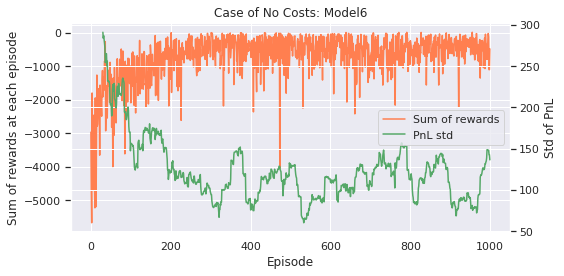

In [81]:
f_dqn0 = open(os.getcwd()+"/models/dqn_30_0.json")
data_dqn0 = json.load(f_dqn0)
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(data_dqn0["rewards"], color='coral', label='Sum of rewards')
ax.set_xlabel('Episode')
ax.set_ylabel("Sum of rewards at each episode")
h1, l1 = ax.get_legend_handles_labels()
    
ax = ax.twinx()
ax.plot(data_dqn0["PnL_std"], color='g', label='PnL std')
ax.set_ylabel("Std of PnL")
h2, l2 = ax.get_legend_handles_labels()
    
ax.legend(h1+h2, l1+l2, loc='center right')
ax.set_title('Case of No Costs: Model6')
plt.tight_layout()
plt.show()

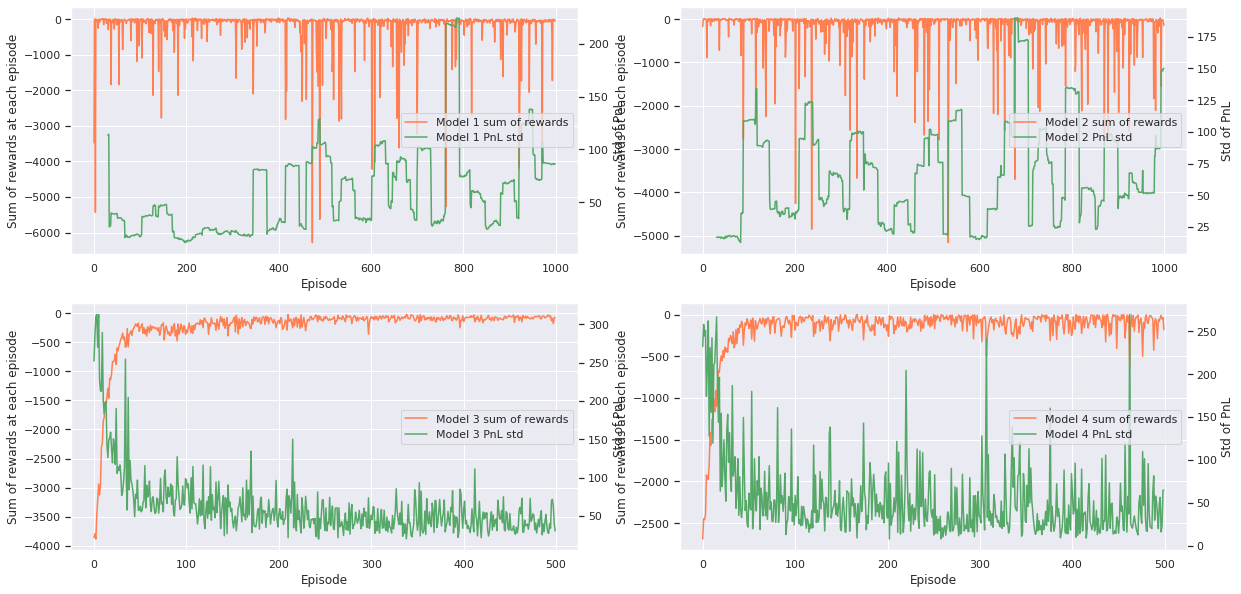

In [83]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

for i in range(2):
    for j in range(2):
        ind = 2 if i==1 else 0
        ax[i][j].plot(datas0[i][j]["rewards"], color="coral", label=f"Model {ind+j+1} sum of rewards")
        ax[i][j].set_xlabel('Episode')
        ax[i][j].set_ylabel("Sum of rewards at each episode")
        h1, l1 = ax[i][j].get_legend_handles_labels()

        ax[i][j] = ax[i][j].twinx()
        ax[i][j].plot(datas0[i][j]["PnL_std"], color="g",label=f"Model {ind+j+1} PnL std")
        ax[i][j].set_ylabel("Std of PnL")
        h2, l2 = ax[i][j].get_legend_handles_labels()
        
        ax[i][j].grid()
        ax[i][j].legend(h1+h2, l1+l2, loc='center right')
        
#ax.set_title("Rewards: zero transaction cost")
#fig.savefig("rewards0.png", bbox_inches='tight')
plt.show()

We first examine the case of zero transaction cost, where all three models have been trained. We train 1000 episodes for DQN and DDPG. Due to the special structure of PPO, we train 500 epoches each containing 30 episodes. The reward of DQN is increasing, showing that the model is learning, though the convergence might not be that significant. Also, the standard deviation of PnL is large and fluctuating, showing within the same training time, DQN cannot reach satisfactory result. The reward of DDPG fluctuates between zero and a very large negative number, showing the instability of the training. The standard deviation is smaller than DQN, but still large and quite unstable. PPO performs best among all three models. The reward increases smoothly without large noise. The standard deviation is also the smallest and most stable.

### Distribution of PnL

In [63]:
env1 = Environment(T, frequency[0], mu, r, sigma, S0, K, option_hold, kappa[0], 0, produce_cost=False)
env2 = Environment(T, frequency[1], mu, r, sigma, S0, K, option_hold, kappa[0], 0, produce_cost=False)
num_simulation=500
M_delta = load_predict(env1, "delta", 30, num_paths=num_simulation)
Model1 = load_predict(env1, "dqn", 30, num_paths=num_simulation)
Model2 = load_predict(env1, "ddpg", 30, num_paths=num_simulation)
Model3 = load_predict(env2, "ddpg", 120, num_paths=num_simulation)
Model4 = load_predict(env1, "ppo", 30, num_paths=num_simulation)
Model5 = load_predict(env2, "ppo", 120, num_paths=num_simulation)

#### Low frequency

In [98]:
def print_mean_variance(series,model_name):
    print(model_name+' Mean:',np.mean(series),',Std:',np.std(series))


/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

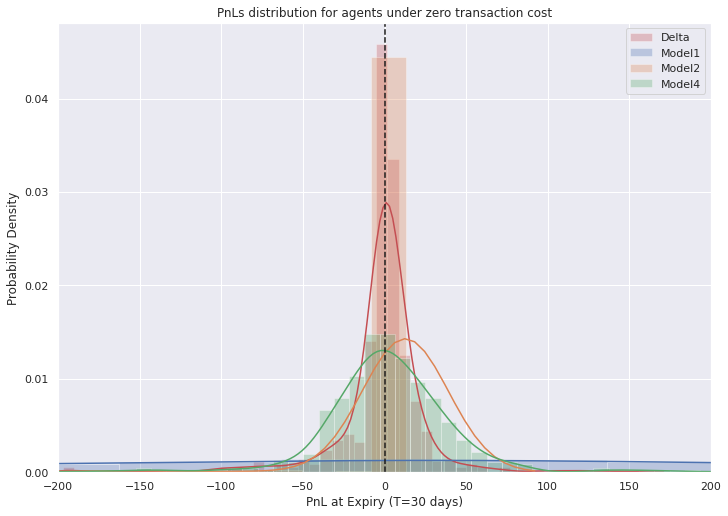

In [97]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(M_delta[1], label="Delta", color="r", hist_kws={"alpha":0.3})
sns.distplot(Model1[1], label="Model1", hist_kws={"alpha":0.3})
sns.distplot(Model2[1] , label="Model2", hist_kws={"alpha":0.3})
sns.distplot(Model4[1] , label="Model4", hist_kws={"alpha":0.3})
plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PnL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('PnLs distribution for agents under zero transaction cost')
plt.legend()
#plt.savefig("PnL.png")
plt.show()

In [101]:
print_mean_variance(M_delta[1],"M_delta")
print_mean_variance(Model1[1],"Model1")
print_mean_variance(Model2[1],"Model2")
print_mean_variance(Model4[1],"Model4")


M_delta Mean: -1.478988178965682 ,Std: 29.25998560125129
Model1 Mean: 11.691793753836505 ,Std: 315.6965679863525
Model2 Mean: -4.739923822841948 ,Std: 91.3368332538984
Model4 Mean: 2.7342844110926254 ,Std: 40.7800140425986


We are interested in the PnL distribution of hedging performed by different agents in simulation. Delta hedging in the case of zero transaction cost should be very close to zero, and the PnL graph clearly shows that, as desired. We suspect that DQN doesn't truly learn about the hedging since the distribution is quite weird. DDPG and PPO have centered mean, and PPO has higher positive PnL. It seems DDPG has more centered PnL distribution, but some extreme values enlarge the variance, making it unstable.

#### High frequency

/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


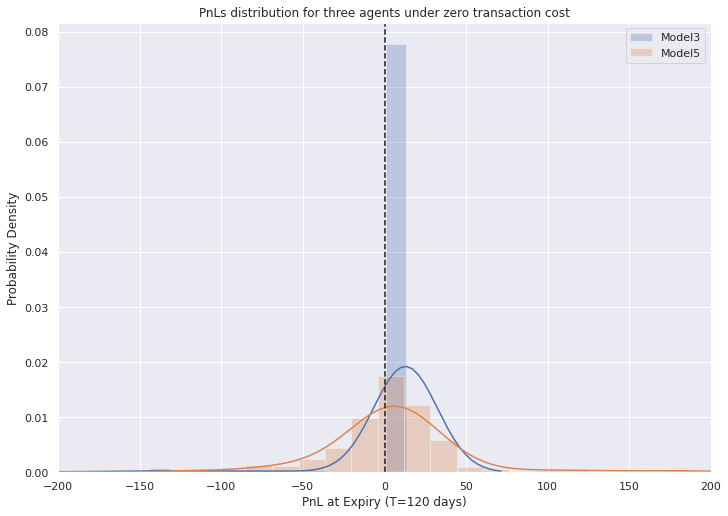

In [ ]:

sns.distplot(Model3[1] , label="Model3", hist_kws={"alpha":0.3})
sns.distplot(Model5[1] , label="Model5", hist_kws={"alpha":0.3})
plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PnL at Expiry (T=120 days)')
plt.ylabel('Probability Density')
plt.title('PnLs distribution for three agents under zero transaction cost')
plt.legend()
#plt.savefig("PnL.png")
plt.show()

In [102]:
print_mean_variance(Model3[1],"Model3")
print_mean_variance(Model5[1],"Model5")

Model3 Mean: -1.0184536723391049 ,Std: 67.5392425800554
Model5 Mean: -0.45936755303709165 ,Std: 68.64610320403625


In the field of high frequency, DDPG presents a very centered distribution of PnL, showing it can deal with most of the cases well. However, still some extreme values lie out of the range. The distribution of PPO is more disperse, but more stable around zero. We can infer that though the training of DDPG is unstable, it usually performs well unless extreme case happens, while PPO always present a stable strategy.

### Actions over different paths

In [69]:
d_t0, d_S0, d_H0 = get_info(M_delta[0])
M1_t0, M1_S0, M1_H0 = get_info(Model1[0])
M2_t0, M2_S0, M2_H0 = get_info(Model2[0])
M3_t0, M3_S0, M3_H0 = get_info(Model3[0])
M4_t0, M4_S0, M4_H0 = get_info(Model4[0])
M5_t0, M5_S0, M5_H0 = get_info(Model5[0])

#### Low frequency

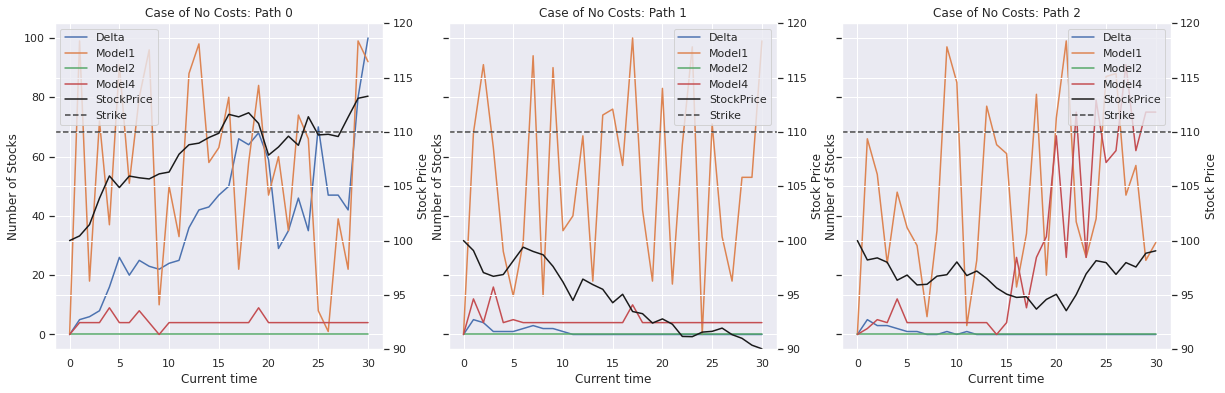

In [74]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=[20,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d_t0[i,:], d_H0[i,:], label='Delta')
    ax.plot(M1_t0[i,:], M1_H0[i,:], label='Model1')
    ax.plot(M2_t0[i,:], M2_H0[i,:], label='Model2')
    ax.plot(M4_t0[i,:], M4_H0[i,:], label='Model4')
    
    ax.set_xlabel('Current time')
    ax.set_ylabel('Number of Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t0[i,:], d_S0[i,:]*110, label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.8)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    #loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

#fig.savefig("paths_zerocost.png", bbox_inches='tight')
plt.show()



The plot presents some strange but reasonable explanation for the difference of DDPG and PPO. We can see that the position of DDPG is always close to zero. When stock price goes up, the option becomes in the money, as the delta moves with the stock. When stock price is always below the strike price, the delta is close to zero. PPO try to switch position to find a good strategy, still kind of stochastic from the perspective of human, while DDPG just gives up on hedging this position. Since our option is simply out of money at the beginning, the probability that the option expires with zero value, is large. When the option expires with no payoff, this strategy simply earns the value of the option at the beginning very probably. And when the option becomes in the money at last, it suffers from large loss with small probability. #### High frequency

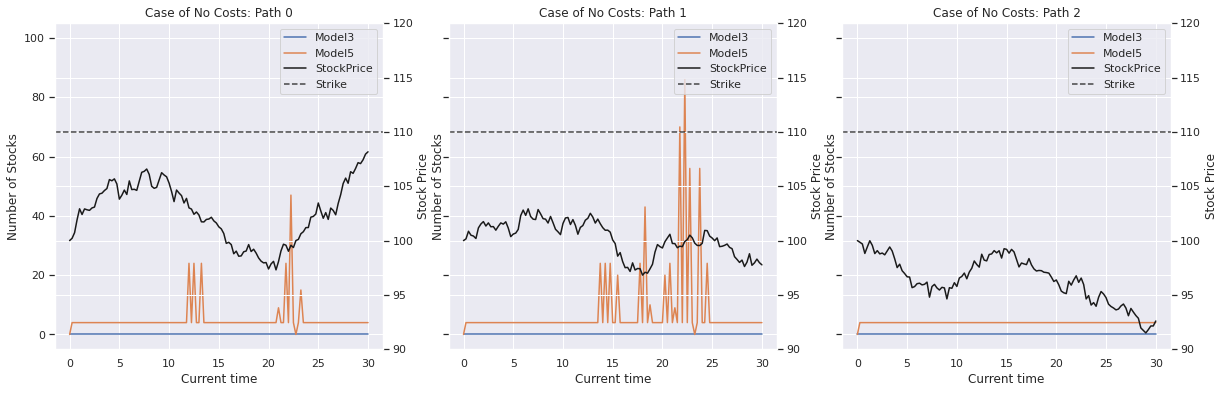

In [75]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=[20,6])
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(M3_t0[i,:], M3_H0[i,:], label='Model3')
    ax.plot(M5_t0[i,:], M5_H0[i,:], label='Model5')
    
    ax.set_xlabel('Current time')
    ax.set_ylabel('Number of Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(M3_t0[i,:], M3_S0[i,:]*110, label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.8)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    #loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

#fig.savefig("paths_zerocost.png", bbox_inches='tight')
plt.show()



The plot presents some strange but reasonable explanation for the difference of DDPG and PPO. We can see that the position of DDPG is always close to zero. When stock price goes up, the option becomes in the money, as the delta moves with the stock. When stock price is always below the strike price, the delta is close to zero. PPO try to switch position to find a good strategy, still kind of stochastic from the perspective of human, while DDPG just gives up on hedging this position. Since our option is simply out of money at the beginning, the probability that the option expires with zero value, is large. When the option expires with no payoff, this strategy simply earns the value of the option at the beginning very probably. And when the option becomes in the money at last, it suffers from large loss with small probability. 

## Performances of agents (non-zero cost)

### Rewards and PnL standard deviation during training

In [84]:
freqs = ["30", "120"]
models = ["ddpg","ppo"]
alphs = ["0.002", "0.008"]

In [86]:
datas1 = [[],[]]

#f_dqn1 = open("models/dqn0.json")
#data_dqn1 = json.load(f)
for i in range(2):
    for j in range(2):
        for alph in alphs:
            model = models[i]
            freq = freqs[j]
            path_name = os.getcwd()+"/models/"+model+"_"+freq+"_"+alph+"_"+"1"+".json"
            f = open(path_name)
            data = json.load(f)
            datas1[i].append(data)

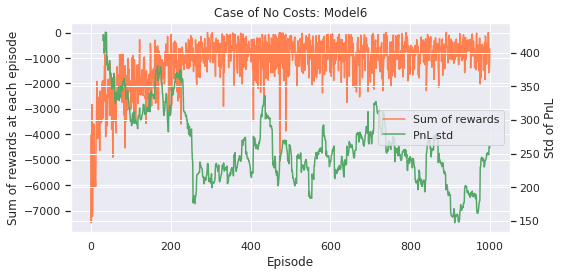

In [88]:
f_dqn1 = open(os.getcwd()+"/models/dqn_30_0.008_1.json")
data_dqn1 = json.load(f_dqn1)
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(data_dqn1["rewards"], color='coral', label='Sum of rewards')
ax.set_xlabel('Episode')
ax.set_ylabel("Sum of rewards at each episode")
h1, l1 = ax.get_legend_handles_labels()
    
ax = ax.twinx()
ax.plot(data_dqn1["PnL_std"], color='g', label='PnL std')
ax.set_ylabel("Std of PnL")
h2, l2 = ax.get_legend_handles_labels()
    
ax.legend(h1+h2, l1+l2, loc='center right')
ax.set_title('Case of No Costs: Model6')
plt.tight_layout()
plt.show()

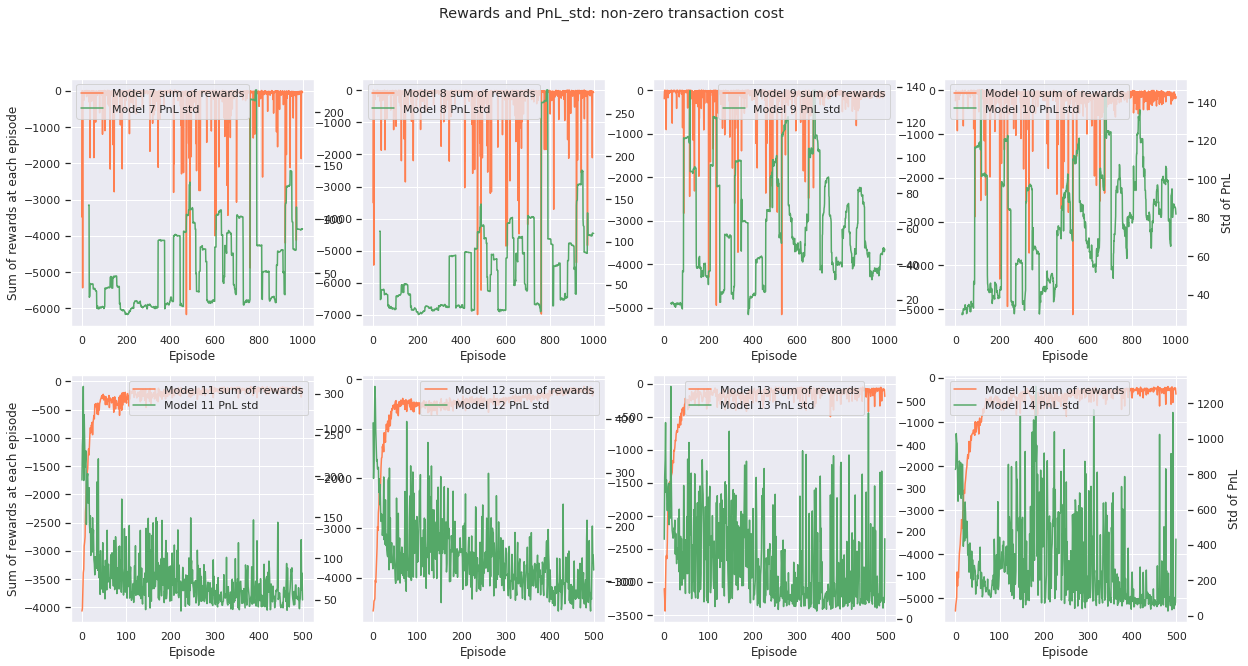

In [89]:
fig, ax = plt.subplots(2,4, figsize=(20,10))

for i in range(2):
    for j in range(4):
        ind = 4 if i==1 else 0
        ax[i][j].plot(datas1[i][j]["rewards"], color='coral', label=f"Model {ind+j+7} sum of rewards")
        ax[i][j].set_xlabel('Episode')
        if j==0:
          ax[i][j].set_ylabel("Sum of rewards at each episode")
        h1, l1 = ax[i][j].get_legend_handles_labels()

        ax[i][j] = ax[i][j].twinx()
        ax[i][j].plot(datas1[i][j]["PnL_std"], color='g', label=f"Model {ind+j+7} PnL std")
        if j==3:
          ax[i][j].set_ylabel("Std of PnL")
        h2, l2 = ax[i][j].get_legend_handles_labels()
        
        ax[i][j].grid()
        ax[i][j].legend(h1+h2, l1+l2)
        
plt.suptitle("Rewards and PnL_std: non-zero transaction cost")
#fig.savefig("rewards0.png", bbox_inches='tight')
plt.show()

The first row represents the cumulative rewards over each path of DDPG agent and the second row correspondes to PPO agent. Each model is detailed at the **Implementation** part. It is obvious that DDPG agents do not converge well while all PPO agents have good convergence property. Specific to each model, Model 7 and Model 8 are hard to converge, where low frequency was applied. However, DDPG seems to perform better with high frequency (Model 9 and Model 10). PPO has relative good convergence under all circumstances, but suffer from unstability when traded with high frequency. 

### Distribution of PnL

In [91]:
env1 = Environment(T, frequency[0], mu, r, sigma, S0, K, option_hold, kappa[0], 0.002)
env2 = Environment(T, frequency[0], mu, r, sigma, S0, K, option_hold, kappa[0], 0.008)
env3 = Environment(T, frequency[1], mu, r, sigma, S0, K, option_hold, kappa[0], 0.002)
env4 = Environment(T, frequency[1], mu, r, sigma, S0, K, option_hold, kappa[0], 0.008)

M1_delta = load_predict(env1, "delta", 30, 0.002,num_paths=num_simulation,cost=True)
M2_delta = load_predict(env2, "delta", 30, 0.008,num_paths=num_simulation,cost=True)

Model6 = load_predict(env2, "dqn", 30, 0.008, num_paths=num_simulation,cost=True)

Model7 = load_predict(env1, "ddpg", 30, 0.002, num_paths=num_simulation,cost=True)
Model8 = load_predict(env2, "ddpg", 30, 0.008, num_paths=num_simulation,cost=True)
Model9 = load_predict(env3, "ddpg", 120,0.002, num_paths=num_simulation,cost=True)
Model10 = load_predict(env4, "ddpg", 120,0.008, num_paths=num_simulation,cost=True)

Model11 = load_predict(env1, "ppo", 30, 0.002, num_paths=num_simulation,cost=True)
Model12 = load_predict(env2, "ppo", 30, 0.008, num_paths=num_simulation,cost=True)
Model13 = load_predict(env3, "ppo", 120, 0.002, num_paths=num_simulation,cost=True)
Model14 = load_predict(env4, "ppo", 120,0.008, num_paths=num_simulation,cost=True)

#### Low frequency, Low transaction fee

/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

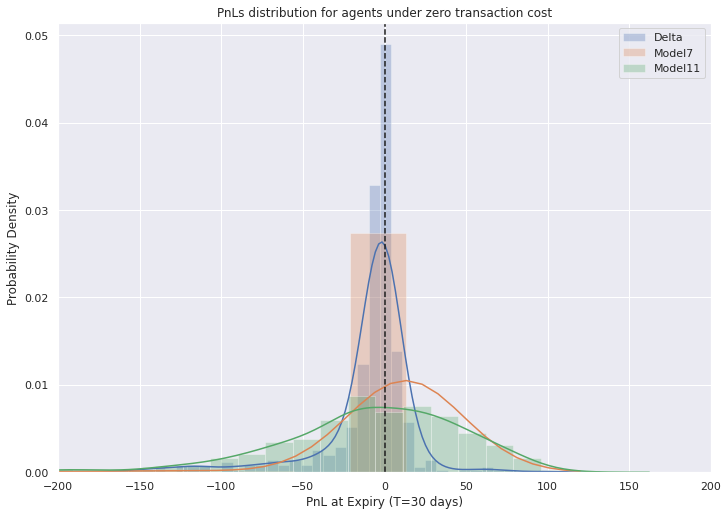

In [92]:
sns.distplot(M1_delta[1], label="Delta", hist_kws={"alpha":0.3})
sns.distplot(Model7[1] , label="Model7", hist_kws={"alpha":0.3})
sns.distplot(Model11[1], label="Model11", hist_kws={"alpha":0.3})

plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PnL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('PnLs distribution for agents under zero transaction cost')
plt.legend()
#plt.savefig("PnL.png")
plt.show()

In [103]:
print_mean_variance(M1_delta[1],"M1_delta")
print_mean_variance(Model7[1],"Model7")
print_mean_variance(Model11[1],"Model11")


M1_delta Mean: -11.590003821395594 ,Std: 35.208902521309504
Model7 Mean: -11.460492986455074 ,Std: 123.46931878217995
Model11 Mean: -9.102420483316676 ,Std: 57.4315570326297


As a low transaction cost is introduced in low frequency hedging, the PnL is drifted away to a negative number. PnL for Delta hedging is still stably negative with very low variance. The mean for PnL generated by DDPG is almost the same amount to the Delta Hedging, but the variance is quite large. PPO lowers the cost of hedging in average, with an acceptable  variance. 

#### Low frequency, High transaction fee

/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

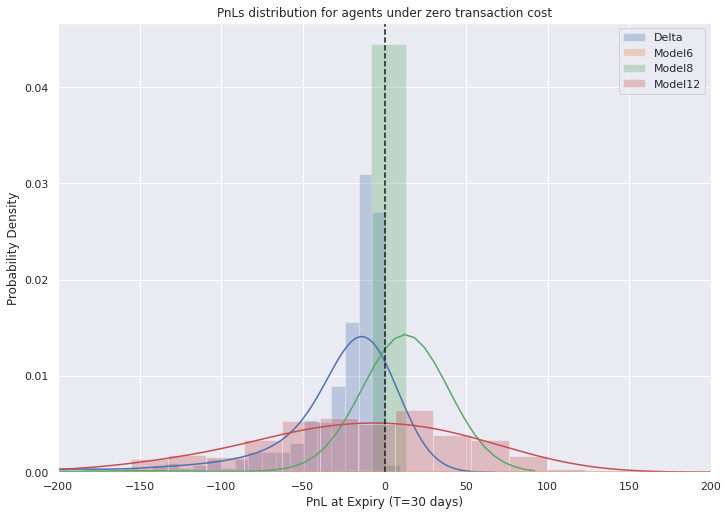

In [93]:
sns.distplot(M2_delta[1], label="Delta", hist_kws={"alpha":0.3})
sns.distplot(Model6[1] , label="Model6", hist_kws={"alpha":0.3})
sns.distplot(Model8[1], label="Model8", hist_kws={"alpha":0.3})
sns.distplot(Model12[1], label="Model12", hist_kws={"alpha":0.3})

plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PnL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('PnLs distribution for agents under zero transaction cost')
plt.legend()
#plt.savefig("PnL.png")
plt.show()

In [105]:
print_mean_variance(M2_delta[1],"M2_delta")
print_mean_variance(Model6[1],"Model6")
print_mean_variance(Model8[1],"Model8")
print_mean_variance(Model12[1],"Model12")

M2_delta Mean: -41.923050748685334 ,Std: 67.30870544755747
Model6 Mean: -1163.2633399686538 ,Std: 361.3497751092225
Model8 Mean: -4.739923822841948 ,Std: 91.3368332538984
Model12 Mean: -43.00353341667479 ,Std: 124.0539845364652


When frequency is still low but transaction cost is high, the case is more complex. Delta hedging is still stable, but the cost is much higher. DQN truly learns nothing. DDPG saves a lot of costs while being stable as well. PPO doesn't truly save the costs, as well as doesn't perform stably.

#### High frequency, Low transaction fee

/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


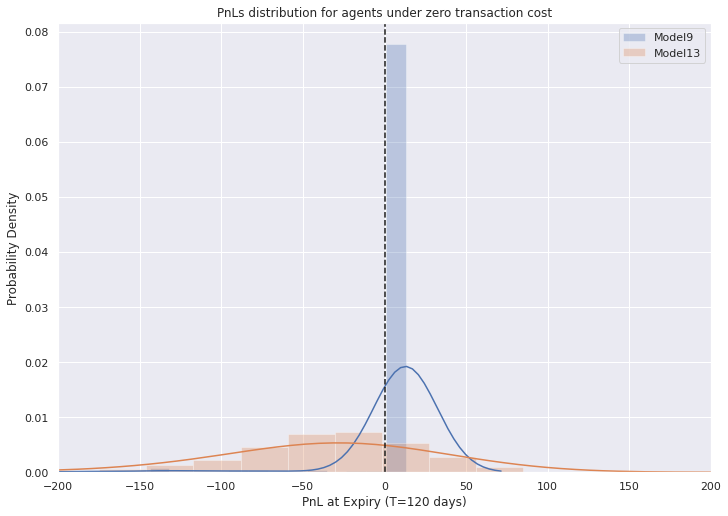

In [94]:
sns.distplot(Model9[1] , label="Model9", hist_kws={"alpha":0.3})
sns.distplot(Model13[1], label="Model13", hist_kws={"alpha":0.3})

plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PnL at Expiry (T=120 days)')
plt.ylabel('Probability Density')
plt.title('PnLs distribution for agents under zero transaction cost')
plt.legend()
#plt.savefig("PnL.png")
plt.show()

In [106]:
print_mean_variance(Model9[1],"Model9")
print_mean_variance(Model13[1],"Model13")

Model9 Mean: -1.0184536723391049 ,Std: 67.5392425800554
Model13 Mean: -70.87769639628937 ,Std: 167.30145907054353


When frequency is still high and transaction cost is low. DDPG fully outperforms PPO by having smaller variance and higher mean in PnL.

#### High frequency, High transaction fee

/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/environment/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


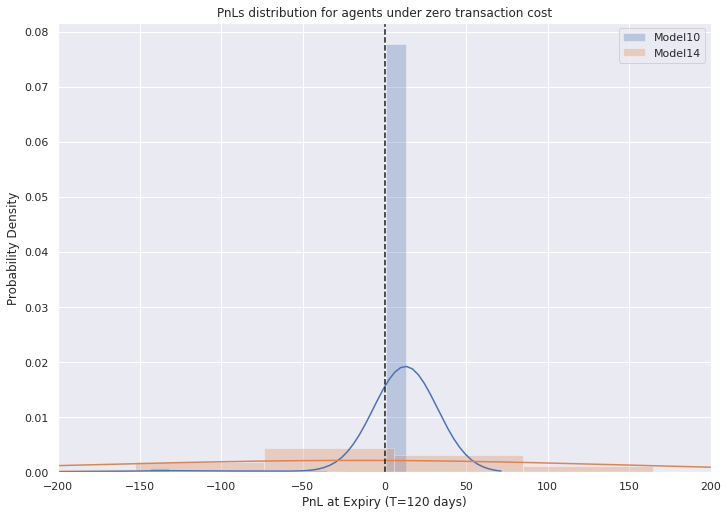

In [95]:
sns.distplot(Model10[1], label="Model10", hist_kws={"alpha":0.3})
sns.distplot(Model14[1], label="Model14", hist_kws={"alpha":0.3})

plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PnL at Expiry (T=120 days)')
plt.ylabel('Probability Density')
plt.title('PnLs distribution for agents under zero transaction cost')
plt.legend()
#plt.savefig("PnL.png")
plt.show()

In [108]:
print_mean_variance(Model10[1],"Model10")
print_mean_variance(Model14[1],"Model14")

Model10 Mean: -1.0184536723391049 ,Std: 67.5392425800554
Model14 Mean: -151.04980586477768 ,Std: 506.7989751719313


Under the circumstance when frequency and high transaction are both high, PPO fails to hedge well, while DDPG has a consistent and trust-worthy performance.

### Actions over different paths

In [109]:
d1_t0, d1_S0, d1_H0 = get_info(M1_delta[0])
d2_t0, d2_S0, d2_H0 = get_info(M2_delta[0])
M6_t0, M6_S0, M6_H0 = get_info(Model6[0])
M7_t0, M7_S0, M7_H0 = get_info(Model7[0])
M8_t0, M8_S0, M8_H0 = get_info(Model8[0])
M9_t0, M9_S0, M9_H0 = get_info(Model9[0])
M10_t0, M10_S0, M10_H0 = get_info(Model10[0])
M11_t0, M11_S0, M11_H0 = get_info(Model11[0])
M12_t0, M12_S0, M12_H0 = get_info(Model12[0])
M13_t0, M13_S0, M13_H0 = get_info(Model13[0])
M14_t0, M14_S0, M14_H0 = get_info(Model14[0])

#### Low frequency, Low transaction fee

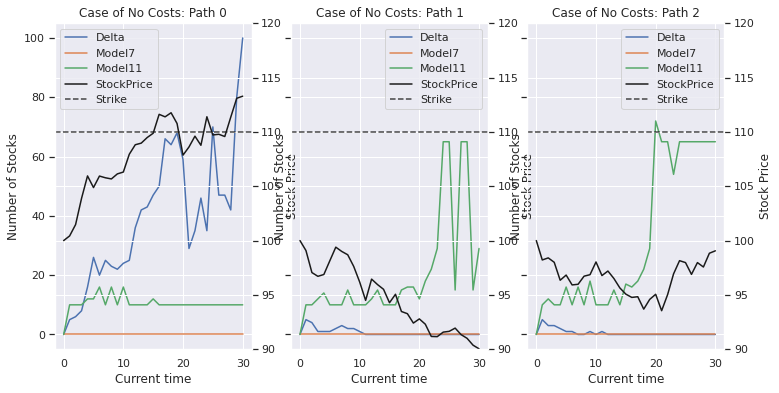

In [110]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=[12,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d1_t0[i,:], d1_H0[i,:], label='Delta')
    ax.plot(M7_t0[i,:], M7_H0[i,:], label='Model7')
    ax.plot(M11_t0[i,:], M11_H0[i,:], label='Model11')
    
    ax.set_xlabel('Current time')
    ax.set_ylabel('Number of Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t0[i,:], d_S0[i,:]*110, label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.8)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    #loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

#fig.savefig("paths_zerocost.png", bbox_inches='tight')
plt.show()

#### Low frequency, High transaction fee

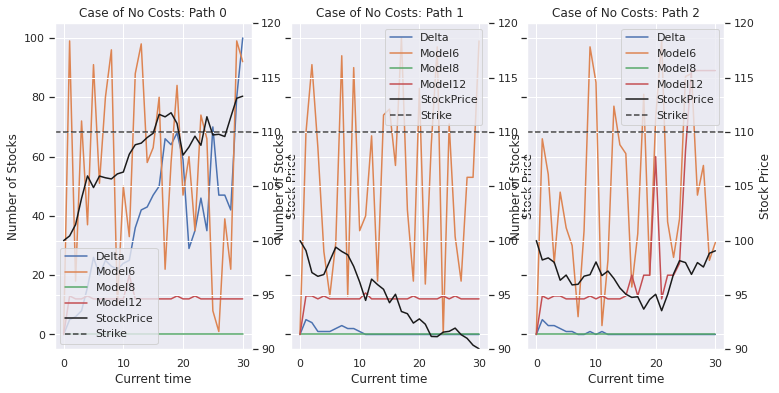

In [111]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=[12,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d2_t0[i,:], d2_H0[i,:], label='Delta')
    ax.plot(M6_t0[i,:], M6_H0[i,:], label='Model6')
    ax.plot(M8_t0[i,:], M8_H0[i,:], label='Model8')
    ax.plot(M12_t0[i,:], M12_H0[i,:], label='Model12')
    
    ax.set_xlabel('Current time')
    ax.set_ylabel('Number of Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t0[i,:], d_S0[i,:]*110, label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.8)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    #loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

#fig.savefig("paths_zerocost.png", bbox_inches='tight')
plt.show()

#### High frequency, Low transaction fee

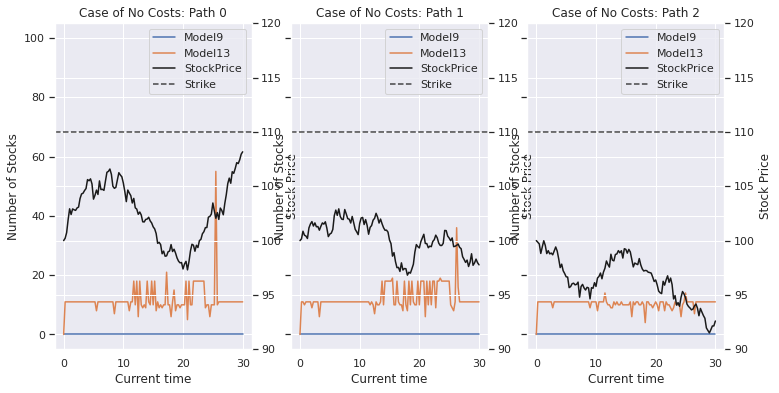

In [112]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=[12,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(M9_t0[i,:], M9_H0[i,:], label='Model9')
    ax.plot(M13_t0[i,:], M13_H0[i,:], label='Model13')
    
    ax.set_xlabel('Current time')
    ax.set_ylabel('Number of Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(M9_t0[i,:], M9_S0[i,:]*110, label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.8)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    #loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

#fig.savefig("paths_zerocost.png", bbox_inches='tight')
plt.show()

#### High frequency, High transaction fee

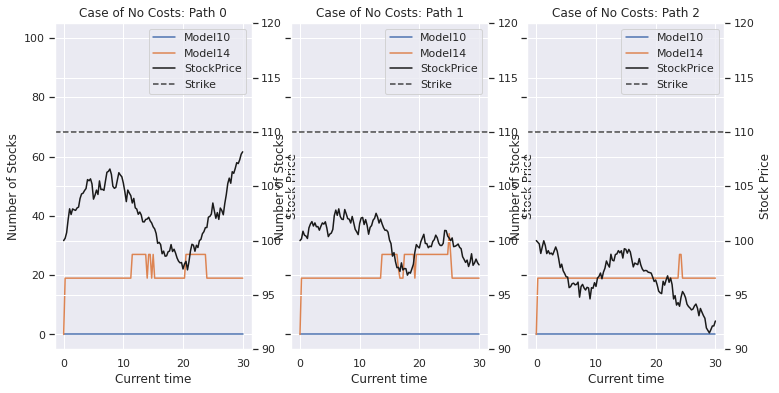

In [113]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=[12,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(M10_t0[i,:], M10_H0[i,:], label='Model10')
    ax.plot(M14_t0[i,:], M14_H0[i,:], label='Model14')
    
    ax.set_xlabel('Current time')
    ax.set_ylabel('Number of Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(M10_t0[i,:], M10_S0[i,:]*110, label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.8)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    #loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

#fig.savefig("paths_zerocost.png", bbox_inches='tight')
plt.show()

When there are transaction costs, the strategies of DDPG and PPO are just similar to one described in the previous section.

# Conclusion

The main aim of this proejct is to show that RL algorithms can be trained to hedge an option under realistic conditions. We have trained models under several circumstances and evaluated their performances. It would be interesting to investigate optimal hedging strategies for portfolios of options in the presence of trading costs. Obviously, when stock price is deep in the money or out of money, delta-hedging would not be needed so frequently, thus naturally reducing the trading costs for that kind of portfolio. DDPG uses this property and chooses not to hedge at all, while an effective hedging strategy is still to be explored for PPO. In general, the most effective approach to reduce variance is likely to use other options rather than a replicating portfolio. The results are subject to our limited computational resources, while it takes too long to train deep network with enough number of episodes. More work is worth further explored in this area.

# References
Halperin 2017, https://arxiv.org/abs/1712.04609

Ritter 2017, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3281235

Silver 2015,  http://files.davidqiu.com//research/nature14236.pdf

Silver 2014, http://proceedings.mlr.press/v32/silver14.pdf

Du 2020, https://cims.nyu.edu/~ritter/du2020deep.pdf

Keras tutorial on PPO https://keras.io/examples/rl/ppo_cartpole/

Schulman 2017, PPO https://arxiv.org/abs/1707.06347

Lillicrap 2015, DDPG https://arxiv.org/abs/1509.02971

Mnih 2013, DQN https://arxiv.org/abs/1312.5602